<a href="https://colab.research.google.com/github/pryplotsky/C5.-Deep-Survival-Analysis-and-Time-Varying-Covariates/blob/main/CPH0015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cox Time model is taken from:
https://lifelines.readthedocs.io/en/latest/Time%20varying%20survival%20regression.html

In [ ]:
#Some basic istructions:
# 1. Each line of code must be FULLY DOCUMENTED
# 2. Everything should be inside a class(classes) or functions if you don't know OOP
# 3. Please avoid using values (numbers/string/....) use instead variables
# 4. Use default values for your function arguments whenever possible

#Plan:
# We need functions/methods for:
# 1. Read, save and load a data - DONE
# 2. Pre-process the data (if needed) - DONE
# 3. Split the data into 3 sets: train(80%)  + dev (10%) + test(10%) - DONE
# 4. Obtain relevant statistics (if needed) - NOT NOW
# 5. Create Cox time ( CPH for TVC) model - In Progress
# a) Calculate C index for test set
# b) Kaplan-Meier curve (total survival distribution)
# c) Excample for 5 random observations (individual survival distribution)
# d) I don't thing CoxTimeVaryingFitter is a neutonal network. I think is a classic Cox proportional hasard, because ve dont have:
# loss function, any parametrs for validation...

In [1]:
### Install  packages and define global variables
#Basic:
import pandas as pd
import numpy as np
# 1. Read, save and load a data:
import os
import pickle
# 2. Pre-process the data 
from sklearn import preprocessing
# 3. Split the data into 3 sets
import sklearn
from sklearn.model_selection import train_test_split
# 5. Create Cox time ( CPH for TVC) model
!pip install lifelines
import matplotlib.pyplot as plt
from lifelines import CoxTimeVaryingFitter
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from sklearn.metrics import brier_score_loss

**Main part of code**

In [29]:
### Create class Preparation with 5 methods: __init__, readdf, save, load, cleaning and splitdata
class Preparation:
  def __init__(self):# Dont use any additional attributes    
    self.df = None # Placeholders. Set varabels as none and then update a resut 
    self.X_train = None
    self.X_test = None
    self.y_train = None
    self.y_test  = None
    self.X_train = None
    self.X_val = None
    self.y_train = None
    self.y_val = None
    self.cols_standardize = ['id', 'tte', 'times','label',
       'balance_time', 'LTV_time', 'interest_rate_time', 'rate_time',
       'hpi_time', 'gdp_time', 'uer_time','avg_balance_time', 'avg_interest_rate_time',
       'avg_LTV_time', 'avg_rate_time', 'avg_hpi_time', 'avg_gdp_time',
       'avg_uer_time','FICO_orig_time', 'REtype_CO_orig_time',
       'REtype_PU_orig_time', 'REtype_SF_orig_time', 'default_time', 'payoff_time']
    #self.cols_standardize = ['rate_time','hpi_time', 'gdp_time']
### Pre-processing:
  # Read data
  def readdf (self, sep=",", filename="dcr_cleaned.csv", cwd = os.getcwd()): # Method whith 3 def attributes: sep - separator, getcwd - path to your working directory
    file_name = cwd + "/" + filename # Get path of file
    data = pd.read_csv(file_name, sep= sep) # Read csv
    self.df = data # Save filtered dataset 
    return self.df # Print dataset
  # Clean data
  def cleaning (self, data,longformat=True,individual="id", stop="times", stopname="start"): 
    if longformat:# Bring data into long format (necessary for using the lifeline package's Cox’s time varying proportional hazard model) 
        data[stopname] = data.groupby(individual)[stop].shift(1)
        data[stopname] = data[stopname].fillna(0)
        self.df = data # Save filtered dataset
        return self.df # Print dataset
### Saving and load objects as binary mode
  def save (self, dataname, dataframe , cwd = os.getcwd()):# Saving and load objects as binary mode
    with open( cwd + '/' + dataname + '.pkl','wb') as path_name: # save df, 'wb' specifies 'write'
      pickle.dump(dataframe, path_name)  
  def load (self, dataname, cwd = os.getcwd()):# Saving and load objects as binary mode
    with open( cwd + '/' + dataname + '.pkl' ,'rb') as path_name:# load df, 'rb' specifies 'read'
      dataframe = pickle.load(path_name)
      return dataframe # Print dataset
### Split the data into 3 sets: train(80%)  + dev (10%) + test(10%)  
  def splitdata (self, Xvar, yvar, perc_test=0.2, perc_val=1/5,  shuffle=False):# Method needs 5 arguments: X set with independent vars, y - set w. dependent vars, perc_test=percentage for test set, perc_val=valuation set (=(1-perc_test)*perc_val) 
    self.X_train, self.X_test, self.y_train, self.y_test = sklearn.model_selection.train_test_split(Xvar, yvar, test_size=perc_test,random_state=1234,  shuffle=shuffle)# Split data not randomly to train 90% and test 10%
    self.X_train, self.X_val, self.y_train, self.y_val = sklearn.model_selection.train_test_split(self.X_train, self.y_train, test_size=perc_test,random_state=1234,  shuffle=shuffle) # Split train data not randomly to train 80% and valid 10%
    print(len(self.X_train), len(self.X_val), len(self.X_test)) # len - length 

**Testing**

In [32]:
temp=Preparation()
newdf = temp.readdf()

df_to_use=temp.cleaning(temp.df)

df_to_use

,id,tte,times,label,balance_time,LTV_time,interest_rate_time,rate_time,hpi_time,gdp_time,uer_time,avg_balance_time,avg_interest_rate_time,avg_LTV_time,avg_rate_time,avg_hpi_time,avg_gdp_time,avg_uer_time,FICO_orig_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,default_time,payoff_time,start
0,1,61,25,0,61031.10,33.911009,10.500,5.90,226.29,2.899137,4.7,57546.403143,10.107143,41.626867,5.90,176.642286,1.264322,7.162857,587,0,0,1,0,0,0.0
1,1,61,26,0,60882.42,34.007232,10.500,5.90,225.10,2.151365,4.7,57546.403143,10.107143,41.626867,5.90,176.642286,1.264322,7.162857,587,0,0,1,0,0,25.0
2,1,61,27,0,60729.80,34.335349,10.500,5.90,222.39,2.361722,4.4,57546.403143,10.107143,41.626867,5.90,176.642286,1.264322,7.162857,587,0,0,1,0,0,26.0
3,1,61,28,0,60576.14,34.672545,10.875,5.90,219.67,1.229172,4.6,57546.403143,10.107143,41.626867,5.90,176.642286,1.264322,7.162857,587,0,0,1,0,0,27.0
4,1,61,29,0,60424.39,34.951639,10.875,5.90,217.37,1.692969,4.5,57546.403143,10.107143,41.626867,5.90,176.642286,1.264322,7.162857,587,0,0,1,0,0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62173,5000,57,52,0,180673.24,103.306966,7.500,5.15,161.13,1.081049,8.0,179594.992000,7.500000,94.669146,5.15,175.154000,1.524146,7.340000,708,0,0,1,0,0,0.0
62174,5000,57,53,0,179944.95,95.736862,7.500,5.15,173.17,0.892996,7.6,179594.992000,7.500000,94.669146,5.15,175.154000,1.524146,7.340000,708,0,0,1,0,0,52.0
62175,5000,57,54,0,179451.81,91.867079,7.500,5.15,179.97,1.507359,7.3,179594.992000,7.500000,94.669146,5.15,175.154000,1.524146,7.340000,708,0,0,1,0,0,53.0
62176,5000,57,55,0,178952.48,91.560581,7.500,5.15,180.07,2.422275,7.2,179594.992000,7.500000,94.669146,5.15,175.154000,1.524146,7.340000,708,0,0,1,0,0,54.0


In [36]:
temp=Preparation()
newdf = temp.readdf()

df_to_use=temp.cleaning(temp.df)
temp.splitdata(df_to_use.loc[:,df_to_use.columns != 'label'], yvar=df_to_use['label'])
temp.X_train

39793 9949 12436


,id,tte,times,balance_time,LTV_time,interest_rate_time,rate_time,hpi_time,gdp_time,uer_time,avg_balance_time,avg_interest_rate_time,avg_LTV_time,avg_rate_time,avg_hpi_time,avg_gdp_time,avg_uer_time,FICO_orig_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,default_time,payoff_time,start
0,1,61,25,61031.10,33.911009,10.500,5.90,226.29,2.899137,4.7,57546.403143,10.107143,41.626867,5.90,176.642286,1.264322,7.162857,587,0,0,1,0,0,0.0
1,1,61,26,60882.42,34.007232,10.500,5.90,225.10,2.151365,4.7,57546.403143,10.107143,41.626867,5.90,176.642286,1.264322,7.162857,587,0,0,1,0,0,25.0
2,1,61,27,60729.80,34.335349,10.500,5.90,222.39,2.361722,4.4,57546.403143,10.107143,41.626867,5.90,176.642286,1.264322,7.162857,587,0,0,1,0,0,26.0
3,1,61,28,60576.14,34.672545,10.875,5.90,219.67,1.229172,4.6,57546.403143,10.107143,41.626867,5.90,176.642286,1.264322,7.162857,587,0,0,1,0,0,27.0
4,1,61,29,60424.39,34.951639,10.875,5.90,217.37,1.692969,4.5,57546.403143,10.107143,41.626867,5.90,176.642286,1.264322,7.162857,587,0,0,1,0,0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39788,3252,61,32,288202.60,64.941714,5.625,5.15,186.12,1.104163,5.0,274615.469722,5.625000,66.400248,5.15,176.141111,1.264453,7.180556,766,0,0,0,0,0,31.0
39789,3252,61,33,287114.96,66.703619,5.625,5.15,180.52,0.836859,5.0,274615.469722,5.625000,66.400248,5.15,176.141111,1.264453,7.180556,766,0,0,0,0,0,32.0
39790,3252,61,34,286056.27,69.206442,5.625,5.15,173.35,-0.314448,5.8,274615.469722,5.625000,66.400248,5.15,176.141111,1.264453,7.180556,766,0,0,0,0,0,33.0
39791,3252,61,35,284982.01,73.736093,5.625,5.15,162.09,-2.805844,6.5,274615.469722,5.625000,66.400248,5.15,176.141111,1.264453,7.180556,766,0,0,0,0,0,34.0


**Cox Time**

In [121]:
result_c_index=[]
result_brier_score=[]
pred_time=[21, 23, 40, 50]
#var_list=['id','time','start','rate_time', 'gdp_time','hpi_time','default_time']
k_event=['default_time', 'payoff_time']


In [115]:
def brier_score(Prediction, Time_survival, Death, Time):
    N = len(Prediction)
    y_true = ((Time_survival <= Time) * Death).astype(float)
    return np.mean((Prediction - y_true.values)**2)


39793 9949 12436
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -7055.17008, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 39793 periods, 3252 subjects, 1007 events>
         event col = 'default_time'
         penalizer = 0.1
number of subjects = 3252
 number of periods = 39793
  number of events = 1007
partial log-likelihood = -7055.17
  time fit was run = 2021-08-28 11:06:05 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
tte                 -0.02       0.98       0.00            -0.02            -0.01                 0.98                 0.99
balance_time        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
LTV_time             0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
interest_rate_time   0.03       1.03       0.01             0.02             0.04                 1.02                 1.04
rate_time            0.05       1.05       0.03            -0.00             0.11                 1.00                 1.11
hpi_time            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gdp_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
uer_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                        z      p   -log2(p)
covariate                                  
tte                -14.24 <0.005     150.51
balance_time        -1.06   0.29       1.79
LTV_time             3.07 <0.005       8.87
interest_rate_time   4.47 <0.005      16.95
rate_time            1.94   0.05       4.26
hpi_time            -1.21   0.23       2.15
gdp_time             0.20   0.85       0.24
uer_time             0.23   0.82       0.29
FICO_orig_time      -5.31 <0.005      23.10
---
Partial AIC = 14128.34
log-likelihood ratio test = 279.78 on 9 df
-log2(p) of ll-ratio test = 180.37

Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -7055.17008, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 39793 periods, 3252 subjects, 1007 events>
         event col = 'default_time'
         penalizer = 0.1
number of subjects = 3252
 number of periods = 39793
  number of events = 1007
partial log-likelihood = -7055.17
  time fit was run = 2021-08-28 11:06:06 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
tte                 -0.02       0.98       0.00            -0.02            -0.01                 0.98                 0.99
balance_time        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
LTV_time             0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
interest_rate_time   0.03       1.03       0.01             0.02             0.04                 1.02                 1.04
rate_time            0.05       1.05       0.03            -0.00             0.11                 1.00                 1.11
hpi_time            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gdp_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
uer_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                        z      p   -log2(p)
covariate                                  
tte                -14.24 <0.005     150.51
balance_time        -1.06   0.29       1.79
LTV_time             3.07 <0.005       8.87
interest_rate_time   4.47 <0.005      16.95
rate_time            1.94   0.05       4.26
hpi_time            -1.21   0.23       2.15
gdp_time             0.20   0.85       0.24
uer_time             0.23   0.82       0.29
FICO_orig_time      -5.31 <0.005      23.10
---
Partial AIC = 14128.34
log-likelihood ratio test = 279.78 on 9 df
-log2(p) of ll-ratio test = 180.37

Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -7055.17008, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 39793 periods, 3252 subjects, 1007 events>
         event col = 'default_time'
         penalizer = 0.1
number of subjects = 3252
 number of periods = 39793
  number of events = 1007
partial log-likelihood = -7055.17
  time fit was run = 2021-08-28 11:06:06 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
tte                 -0.02       0.98       0.00            -0.02            -0.01                 0.98                 0.99
balance_time        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
LTV_time             0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
interest_rate_time   0.03       1.03       0.01             0.02             0.04                 1.02                 1.04
rate_time            0.05       1.05       0.03            -0.00             0.11                 1.00                 1.11
hpi_time            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gdp_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
uer_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                        z      p   -log2(p)
covariate                                  
tte                -14.24 <0.005     150.51
balance_time        -1.06   0.29       1.79
LTV_time             3.07 <0.005       8.87
interest_rate_time   4.47 <0.005      16.95
rate_time            1.94   0.05       4.26
hpi_time            -1.21   0.23       2.15
gdp_time             0.20   0.85       0.24
uer_time             0.23   0.82       0.29
FICO_orig_time      -5.31 <0.005      23.10
---
Partial AIC = 14128.34
log-likelihood ratio test = 279.78 on 9 df
-log2(p) of ll-ratio test = 180.37

Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -7055.17008, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 39793 periods, 3252 subjects, 1007 events>
         event col = 'default_time'
         penalizer = 0.1
number of subjects = 3252
 number of periods = 39793
  number of events = 1007
partial log-likelihood = -7055.17
  time fit was run = 2021-08-28 11:06:07 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
tte                 -0.02       0.98       0.00            -0.02            -0.01                 0.98                 0.99
balance_time        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
LTV_time             0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
interest_rate_time   0.03       1.03       0.01             0.02             0.04                 1.02                 1.04
rate_time            0.05       1.05       0.03            -0.00             0.11                 1.00                 1.11
hpi_time            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gdp_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
uer_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                        z      p   -log2(p)
covariate                                  
tte                -14.24 <0.005     150.51
balance_time        -1.06   0.29       1.79
LTV_time             3.07 <0.005       8.87
interest_rate_time   4.47 <0.005      16.95
rate_time            1.94   0.05       4.26
hpi_time            -1.21   0.23       2.15
gdp_time             0.20   0.85       0.24
uer_time             0.23   0.82       0.29
FICO_orig_time      -5.31 <0.005      23.10
---
Partial AIC = 14128.34
log-likelihood ratio test = 279.78 on 9 df
-log2(p) of ll-ratio test = 180.37

39793 9949 12436
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -13083.29398, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 39793 periods, 3252 subjects, 1783 events>
         event col = 'payoff_time'
         penalizer = 0.1
number of subjects = 3252
 number of periods = 39793
  number of events = 1783
partial log-likelihood = -13083.29
  time fit was run = 2021-08-28 11:06:08 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
tte                 -0.03       0.97       0.00            -0.03            -0.02                 0.97                 0.98
balance_time        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
LTV_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
interest_rate_time   0.01       1.01       0.01             0.00             0.03                 1.00                 1.03
rate_time           -0.09       0.91       0.03            -0.14            -0.04                 0.87                 0.96
hpi_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
gdp_time             0.02       1.03       0.01             0.01             0.04                 1.01                 1.04
uer_time             0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                        z      p   -log2(p)
covariate                                  
tte                -25.57 <0.005     476.51
balance_time        -2.74   0.01       7.33
LTV_time            -6.61 <0.005      34.61
interest_rate_time   2.18   0.03       5.09
rate_time           -3.66 <0.005      11.93
hpi_time            -4.60 <0.005      17.86
gdp_time             3.16 <0.005       9.29
uer_time             1.54   0.12       3.03
FICO_orig_time      -2.23   0.03       5.29
---
Partial AIC = 26184.59
log-likelihood ratio test = 788.11 on 9 df
-log2(p) of ll-ratio test = 541.85

Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -13083.29398, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 39793 periods, 3252 subjects, 1783 events>
         event col = 'payoff_time'
         penalizer = 0.1
number of subjects = 3252
 number of periods = 39793
  number of events = 1783
partial log-likelihood = -13083.29
  time fit was run = 2021-08-28 11:06:09 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
tte                 -0.03       0.97       0.00            -0.03            -0.02                 0.97                 0.98
balance_time        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
LTV_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
interest_rate_time   0.01       1.01       0.01             0.00             0.03                 1.00                 1.03
rate_time           -0.09       0.91       0.03            -0.14            -0.04                 0.87                 0.96
hpi_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
gdp_time             0.02       1.03       0.01             0.01             0.04                 1.01                 1.04
uer_time             0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                        z      p   -log2(p)
covariate                                  
tte                -25.57 <0.005     476.51
balance_time        -2.74   0.01       7.33
LTV_time            -6.61 <0.005      34.61
interest_rate_time   2.18   0.03       5.09
rate_time           -3.66 <0.005      11.93
hpi_time            -4.60 <0.005      17.86
gdp_time             3.16 <0.005       9.29
uer_time             1.54   0.12       3.03
FICO_orig_time      -2.23   0.03       5.29
---
Partial AIC = 26184.59
log-likelihood ratio test = 788.11 on 9 df
-log2(p) of ll-ratio test = 541.85

Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -13083.29398, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 39793 periods, 3252 subjects, 1783 events>
         event col = 'payoff_time'
         penalizer = 0.1
number of subjects = 3252
 number of periods = 39793
  number of events = 1783
partial log-likelihood = -13083.29
  time fit was run = 2021-08-28 11:06:10 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
tte                 -0.03       0.97       0.00            -0.03            -0.02                 0.97                 0.98
balance_time        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
LTV_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
interest_rate_time   0.01       1.01       0.01             0.00             0.03                 1.00                 1.03
rate_time           -0.09       0.91       0.03            -0.14            -0.04                 0.87                 0.96
hpi_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
gdp_time             0.02       1.03       0.01             0.01             0.04                 1.01                 1.04
uer_time             0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                        z      p   -log2(p)
covariate                                  
tte                -25.57 <0.005     476.51
balance_time        -2.74   0.01       7.33
LTV_time            -6.61 <0.005      34.61
interest_rate_time   2.18   0.03       5.09
rate_time           -3.66 <0.005      11.93
hpi_time            -4.60 <0.005      17.86
gdp_time             3.16 <0.005       9.29
uer_time             1.54   0.12       3.03
FICO_orig_time      -2.23   0.03       5.29
---
Partial AIC = 26184.59
log-likelihood ratio test = 788.11 on 9 df
-log2(p) of ll-ratio test = 541.85

Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -13083.29398, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 39793 periods, 3252 subjects, 1783 events>
         event col = 'payoff_time'
         penalizer = 0.1
number of subjects = 3252
 number of periods = 39793
  number of events = 1783
partial log-likelihood = -13083.29
  time fit was run = 2021-08-28 11:06:11 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
tte                 -0.03       0.97       0.00            -0.03            -0.02                 0.97                 0.98
balance_time        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
LTV_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
interest_rate_time   0.01       1.01       0.01             0.00             0.03                 1.00                 1.03
rate_time           -0.09       0.91       0.03            -0.14            -0.04                 0.87                 0.96
hpi_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
gdp_time             0.02       1.03       0.01             0.01             0.04                 1.01                 1.04
uer_time             0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                        z      p   -log2(p)
covariate                                  
tte                -25.57 <0.005     476.51
balance_time        -2.74   0.01       7.33
LTV_time            -6.61 <0.005      34.61
interest_rate_time   2.18   0.03       5.09
rate_time           -3.66 <0.005      11.93
hpi_time            -4.60 <0.005      17.86
gdp_time             3.16 <0.005       9.29
uer_time             1.54   0.12       3.03
FICO_orig_time      -2.23   0.03       5.29
---
Partial AIC = 26184.59
log-likelihood ratio test = 788.11 on 9 df
-log2(p) of ll-ratio test = 541.85

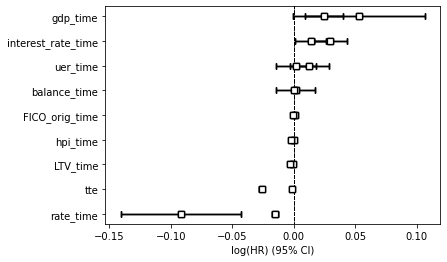

In [122]:
for j in k_event:

  var_list.append(j)
  temp=Preparation()
  newdf = temp.readdf()
  df_to_use=temp.cleaning(temp.df)
  temp.splitdata(df_to_use.loc[:,df_to_use.columns != j], yvar=df_to_use[j]) 
  X_train=temp.X_train
  y_train=temp.y_train
  df_full=X_train[['id', 'tte', 'times',
       'balance_time', 'LTV_time', 'interest_rate_time', 'rate_time',
       'hpi_time', 'gdp_time', 'uer_time','FICO_orig_time',  'start']]
  df2=pd.concat([df_full,  y_train], axis=1)

  #df2b=df2.loc[df2['time']>=(df2['time'].max()-pred_time)]

  df3=df2.dropna()
  for i in pred_time:
    X_test=temp.X_test
    y_test=temp.y_test
    X_test=X_test[['id', 'tte', 'times',
       'balance_time', 'LTV_time', 'interest_rate_time', 'rate_time',
       'hpi_time', 'gdp_time', 'uer_time','FICO_orig_time',  'start']]


    #df_full_test=X_test[var_list]
    df2_test=pd.concat([X_test,  y_test], axis=1)

    df2_testb=df2_test.loc[df2_test['times']<=i]
    #df2_testc=df2_testb.loc[df2_testb['start']<=(pred_time)]

    df3_test=df2_testb.dropna()
    df3_test
    ctv = CoxTimeVaryingFitter(penalizer=0.1)
    ctv.fit(df3, id_col="id", event_col=j, start_col="start", stop_col="times", show_progress=True )
    ctv.print_summary() #summary of the fitted model with different values of the parametric partial hazard and Partial AIC
    ctv.plot() #visiualizaton of the covariates and how they are distributed
    ctv.predict_partial_hazard(df3_test) #predicting the partial hazard
    #survival = KaplanMeierFitter() #
    #survival.fit(df3['time'], df3[j]) #Survival Curve for our dataset
    #survival.plot() #plot the Curve
    #plt.ylabel("Probability of survival")
    #plt.show()
    #plt.close()
    pred=ctv.baseline_cumulative_hazard_['baseline hazard'][i] * ctv.predict_partial_hazard(df3_test)
    res1=concordance_index(df3_test['times'], -pred, df3_test[j])
    #res1=concordance_index(df3_test['time'], -ctv.predict_partial_hazard(df3_test), df3_test[j])
    res2=brier_score(pred, df3_test['times']  ,df3_test[j] , i)
    #res2=brier_score_loss(df3_test[j],pred)
    result_c_index.append(res1)
    result_brier_score.append(res2)

In [123]:
result_c_index

[0.96875,
 0.9510989947180098,
 0.921439551720718,
 0.9458659811125748,
 0.9343806775675965,
 0.9286077272661275,
 0.9734960281861874,
 0.9790642492386715]

In [124]:
result_brier_score

[0.006530914497263452,
 0.00947666511088838,
 0.3264639843648824,
 0.7305599434942966,
 0.07330544444973146,
 0.09718032939019886,
 0.6155452156209551,
 0.8944395042888058]

In [126]:
df_to_print=pd.DataFrame({'Event': k_event*4, 'Time': np.repeat(pred_time, 2 ), 'C-index': result_c_index,'Brier score': result_brier_score })
df_to_print.to_excel('df_res.xlsx')
df_to_print

,Event,Time,C-index,Brier score
0,default_time,21,0.968750,0.006531
1,payoff_time,21,0.951099,0.009477
2,default_time,23,0.921440,0.326464
3,payoff_time,23,0.945866,0.730560
4,default_time,40,0.934381,0.073305
5,payoff_time,40,0.928608,0.097180
6,default_time,50,0.973496,0.615545
7,payoff_time,50,0.979064,0.894440


In [ ]:
import seaborn as sns

corr= df3.corr()

f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr[(corr >= 0.4) | (corr <= -0.4)], #plot a correlation heatmap with only values exceeding absolute 0.30
            annot=True);